In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None)

In [2]:
market_open = pd.Timestamp("09:30:00").time()
market_close = pd.Timestamp("16:00:00").time()

In [3]:
import ta

def add_technical_indicators(df):
    """
    Compute technical indicators for a given DataFrame with OHLC-like structure.
    """
    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    ### TREND INDICATORS ###
    df["ADX_5"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=5
    ).adx()
    df["ADX_7"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=7
    ).adx()
    df["ADX_10"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=10
    ).adx()
    df["DMP_5"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=5
    ).adx_pos()
    df["DMP_10"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=10
    ).adx_pos()
    df["DMN_5"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=5
    ).adx_neg()
    df["DMN_10"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=10
    ).adx_neg()

    # Aroon Indicator requires both high and low prices
    df["AROONU_7"] = ta.trend.AroonIndicator(
        df["mid_price_high"], df["mid_price_low"], window=7
    ).aroon_up()
    df["AROOND_7"] = ta.trend.AroonIndicator(
        df["mid_price_high"], df["mid_price_low"], window=7
    ).aroon_down()

    # Open-Low and Open-High calculations
    df["OLL3"] = df["mid_price_first"] - df["mid_price_low"].rolling(window=3).min()
    df["OLL5"] = df["mid_price_first"] - df["mid_price_low"].rolling(window=5).min()
    df["OLL10"] = df["mid_price_first"] - df["mid_price_low"].rolling(window=10).min()
    df["OLL15"] = df["mid_price_first"] - df["mid_price_low"].rolling(window=15).min()
    df["OHH3"] = df["mid_price_high"].rolling(window=3).max() - df["mid_price_first"]
    df["OHH5"] = df["mid_price_high"].rolling(window=5).max() - df["mid_price_first"]

    ### OSCILLATORS ###
    df["STOCHk_7_3_3"] = ta.momentum.StochasticOscillator(
        df["mid_price_high"],
        df["mid_price_low"],
        df["mid_price_last"],
        window=7,
        smooth_window=3,
    ).stoch()
    df["STOCHd_7_3_3"] = ta.momentum.StochasticOscillator(
        df["mid_price_high"],
        df["mid_price_low"],
        df["mid_price_last"],
        window=7,
        smooth_window=3,
    ).stoch_signal()

    # Avoid NaN Stochastic values
    df["STOCHk_7_3_3"] = df["STOCHk_7_3_3"].ffill()
    df["STOCHd_7_3_3"] = df["STOCHd_7_3_3"].ffill()

    df["MACD_8_21_5"] = ta.trend.MACD(
        df["mid_price_mean"], window_slow=21, window_fast=8, window_sign=5
    ).macd_diff()
    df["RSI_7"] = ta.momentum.RSIIndicator(df["mid_price_mean"], window=7).rsi()
    df["AO_5_10"] = ta.momentum.AwesomeOscillatorIndicator(
        df["mid_price_high"], df["mid_price_low"], window1=5, window2=10
    ).awesome_oscillator()

    ### MOVING AVERAGES ###
    df["EMA_15"] = ta.trend.EMAIndicator(
        df["mid_price_mean"], window=15
    ).ema_indicator()
    df["HMA_10"] = ta.trend.WMAIndicator(
        df["mid_price_mean"], window=10
    ).wma()  # HMA is not directly available in 'ta', using WMA as a placeholder
    df["KAMA_3_2_10"] = ta.momentum.KAMAIndicator(
        df["mid_price_mean"], window=3, pow1=2, pow2=10
    ).kama()
    df["MA_10"] = ta.trend.SMAIndicator(df["mid_price_mean"], window=10).sma_indicator()
    df["MA_20"] = ta.trend.SMAIndicator(df["mid_price_mean"], window=20).sma_indicator()

    # Rolling CO (Last - First)
    for w in [3, 4, 5, 6]:
        df[f"rmCO({w})"] = (
            (df["mid_price_last"] - df["mid_price_first"]).rolling(window=w).mean()
        )

    ### VOLATILITY INDICATORS ###
    df["Bollinger_Upper"] = ta.volatility.BollingerBands(
        df["mid_price_mean"], window=20, window_dev=2
    ).bollinger_hband()
    df["Bollinger_Lower"] = ta.volatility.BollingerBands(
        df["mid_price_mean"], window=20, window_dev=2
    ).bollinger_lband()
    df["U_minus_L"] = df["Bollinger_Upper"] - df["Bollinger_Lower"]
    df["MA20dSTD"] = df["mid_price_last"].rolling(window=20).std()

    ### OTHER INDICATORS ###
    df["CO"] = df["mid_price_last"] - df["mid_price_first"]
    df["C1O1"] = df["CO"].shift(1)
    df["C2O2"] = df["CO"].shift(2)
    df["C3O3"] = df["CO"].shift(3)
    df["range"] = df["mid_price_high"] - df["mid_price_low"]
    df["OH1"] = df["mid_price_high"].shift(1) - df["mid_price_first"].shift(1)

    return df.dropna()

In [4]:
def add_time_features(combined_df):

    # Compute seconds since market open (9:30 AM)
    market_open_time = combined_df.index.normalize() + pd.Timedelta(hours=9, minutes=30)
    combined_df["time_since_open"] = (combined_df.index - market_open_time).dt.total_seconds()

    # Add binary features for Monday and Friday
    combined_df["is_monday"] = (combined_df.index.weekday == 0).astype(int)  # Monday = 0
    combined_df["is_friday"] = (combined_df.index.weekday == 4).astype(int)  # Friday = 4

    # Add market session feature (morning = 0, afternoon = 1)
    combined_df["market_session"] = (combined_df["time_since_open"] > 3.5 * 3600).astype(int)

    return combined_df

In [5]:
def compute_order_book_features(
    raw_data, resample_rate, mid_price_variation_class_threshold=0.0
):

    df = raw_data.copy()

    # Compute the mid-price as the average of best bid/ask prices
    df["mid_price"] = df[["ask_px_00", "bid_px_00"]].mean(axis=1)
    df["mid_price"] = df["mid_price"].fillna(df["ask_px_00"])
    df["mid_price"] = df["mid_price"].fillna(df["bid_px_00"])

    # Compute the bid-ask spread
    df["bid_ask_spread"] = df["ask_px_00"] - df["bid_px_00"]

    # Compute the mid-price as the average of best bid/ask prices
    df["weighted_mid_price"] = (
        df["ask_px_00"] * df["bid_sz_00"] + df["bid_px_00"] * df["ask_sz_00"]
    ) / (df["bid_sz_00"] + df["ask_sz_00"])
    df["weighted_mid_price"] = df["weighted_mid_price"].fillna(df["ask_px_00"])
    df["weighted_mid_price"] = df["weighted_mid_price"].fillna(df["bid_px_00"])

    # Precompute masks for filtering specific actions
    trade_mask = df["action"] == "T"
    add_mask = df["action"] == "A"
    cancel_mask = df["action"] == "C"
    bid_mask = df["side"] == "B"
    ask_mask = df["side"] == "A"

    # Aggregate resampled data using efficient functions
    order_book_data = df.resample(resample_rate).agg(
        {
            "mid_price": ["first", "last", "max", "min", "mean", "std"],
            "weighted_mid_price": ["first", "last", "mean"],
            "bid_ask_spread": ["last", "mean", "std"],
            "bid_px_00": ["last", "mean"],
            "ask_px_00": ["last", "mean"],
            "bid_sz_00": ["last", "mean", "std"],
            "ask_sz_00": ["last", "mean", "std"],
            "ask_px_01": "mean",
            "bid_px_01": "mean",
        }
    )

    # Rename columns for clarity
    order_book_data.columns = [
        "mid_price_first",  # mid price
        "mid_price_last",
        "mid_price_high",
        "mid_price_low",
        "mid_price_mean",
        "std_mid_price",
        "weighted_mid_price_first",  # weighted mid price
        "weighted_mid_price_last",
        "weighted_mid_price_mean",
        "last_spread",  # bid-ask spread
        "mean_spread",
        "std_spread",
        "last_best_bid_price",  # bid price
        "mean_best_bid_price",
        "last_best_ask_price",  # ask price
        "mean_best_ask_price",
        "last_best_bid_size",  # bid size
        "mean_best_bid_size",
        "std_best_bid_size",
        "last_best_ask_size",  # ask size
        "mean_best_ask_size",
        "std_best_ask_size",
        "mean_second_ask_price",  # mean second ask price
        "mean_second_bid_price",  # mean second bid price
    ]

    # When there are no orders for the duration of the sample period, fill with the last available value
    order_book_data[
        [
            "last_best_bid_size",
            "last_best_ask_size",
            "mean_best_bid_size",
            "mean_best_ask_size",
        ]
    ] = order_book_data[
        [
            "last_best_bid_size",
            "last_best_ask_size",
            "mean_best_bid_size",
            "mean_best_ask_size",
        ]
    ].ffill()
    order_book_data[
        [
            "last_best_bid_price",
            "last_best_ask_price",
            "mean_best_bid_size",
            "mean_best_ask_size",
        ]
    ] = order_book_data[
        [
            "last_best_bid_price",
            "last_best_ask_price",
            "mean_best_bid_size",
            "mean_best_ask_size",
        ]
    ].ffill()

    # POSSIBLE TARGETS
    order_book_data["mid_price_variation"] = (
        order_book_data["mid_price_last"] / order_book_data["mid_price_first"] - 1
    )
    # Classify mid-price variations
    order_book_data["mid_price_variation_class"] = order_book_data[
        "mid_price_variation_class"
    ] = (
        np.where(
            np.abs(order_book_data["mid_price_variation"])
            > mid_price_variation_class_threshold,
            np.sign(order_book_data["mid_price_variation"]),
            0,
        )
        + 1
    )
    order_book_data["mean_mid_price_variation"] = (
        order_book_data["mid_price_mean"] / order_book_data["mid_price_first"] - 1
    )
    # Classify mean mid-price variations
    order_book_data["mean_mid_price_variation_class"] = (
        order_book_data["mean_mid_price_variation"] > 0
    ).astype(int)

    order_book_data["weighted_mid_price_variation"] = (
        order_book_data["weighted_mid_price_last"]
        / order_book_data["weighted_mid_price_first"]
        - 1
    )
    # Classify weighted mid-price variations
    order_book_data["weighted_mid_price_variation_class"] = (
        order_book_data["weighted_mid_price_variation"] > 0
    ).astype(int)

    # Compute trade-related values
    trade_prices = (
        df.loc[trade_mask, "price"]
        .resample(resample_rate)
        .agg(["first", "last", "max", "min"])
    )
    trade_prices.columns = ["trade_open", "trade_close", "trade_high", "trade_low"]

    # Compute total bid/ask volume (additions - cancellations)
    order_book_data["total_bid_volume"] = df.loc[add_mask & bid_mask, "size"].astype(
        "int64"
    ).resample(resample_rate).sum().fillna(0) - df.loc[
        cancel_mask & bid_mask, "size"
    ].astype(
        "int64"
    ).resample(
        resample_rate
    ).sum().fillna(
        0
    )
    order_book_data["total_ask_volume"] = df.loc[add_mask & ask_mask, "size"].astype(
        "int64"
    ).resample(resample_rate).sum().fillna(0) - df.loc[
        cancel_mask & ask_mask, "size"
    ].astype(
        "int64"
    ).resample(
        resample_rate
    ).sum().fillna(
        0
    )

    # Compute order book imbalance metrics
    order_book_data["mean_order_book_imbalance"] = (
        order_book_data["mean_best_bid_size"].astype("int64")
        - order_book_data["mean_best_ask_size"].astype("int64")
    ) / (order_book_data["mean_best_bid_size"] + order_book_data["mean_best_ask_size"])

    order_book_data["last_order_book_imbalance"] = (
        order_book_data["last_best_bid_size"].astype("int64")
        - order_book_data["last_best_ask_size"].astype("int64")
    ) / (order_book_data["last_best_bid_size"] + order_book_data["last_best_ask_size"])

    order_book_data["total_net_order_flow"] = order_book_data[
        "last_best_bid_size"
    ].astype("int64") - order_book_data["last_best_ask_size"].astype("int64")

    # Count order actions
    order_book_data["num_added_orders"] = (
        df.loc[add_mask].resample(resample_rate).size()
    )
    order_book_data["num_canceled_orders"] = (
        df.loc[cancel_mask].resample(resample_rate).size()
    )
    order_book_data["num_traded_orders"] = (
        df.loc[trade_mask].resample(resample_rate).size()
    )

    # Compute rolling averages (5s window)
    order_book_data["order_book_imbalance_5s"] = (
        order_book_data["mean_order_book_imbalance"].rolling(5).mean()
    )

    order_book_data["order_flow_5s"] = (
        order_book_data["total_net_order_flow"].rolling(5).mean()
    )

    # Compute bid/ask price/volume variations
    order_book_data["bid_volume_variation"] = (
        order_book_data["last_best_bid_size"].astype("int64").diff()
    )
    order_book_data["ask_volume_variation"] = (
        order_book_data["last_best_ask_size"].astype("int64").diff()
    )
    order_book_data["bid_price_variation"] = (
        order_book_data["last_best_bid_price"].astype("int64").diff()
    )
    order_book_data["ask_price_variation"] = (
        order_book_data["last_best_ask_price"].astype("int64").diff()
    )

    # Merge trade data with resampled data
    order_book_data = order_book_data.merge(
        trade_prices, left_index=True, right_index=True, how="left"
    )

    # Drop NaNs after merging
    order_book_data.dropna(inplace=True)

    return order_book_data

In [6]:
# AAPL_data_path = "AAPL_data/AAPL_2024-10-01_xnas-itch.parquet"

# raw_data = pd.read_parquet(AAPL_data_path)

# raw_data = raw_data.between_time(market_open, market_close)

# order_book_data = compute_order_book_features(raw_data, "1s", mid_price_variation_class_threshold=0.0)
# enriched_data = add_technical_indicators(order_book_data)

# print(enriched_data.columns)
# enriched_data.head()

In [7]:
# order_book_data["weighted_mid_price_variation_class"].value_counts()

In [8]:
# enriched_data["mid_price_variation_class"].value_counts()

# Feature selection

In [9]:
start_date = pd.to_datetime("2024-10-01")
end_date = pd.to_datetime("2024-10-03")
date_range = pd.bdate_range(start=start_date, end=end_date)
data_paths = [f"AAPL_data/AAPL_{date.strftime('%Y-%m-%d')}_xnas-itch.parquet" for date in date_range]

sampling_rate = '1s'

trade_days_data = []

for path in data_paths:
    raw_data = pd.read_parquet(path)
    raw_data = raw_data.reset_index().set_index("ts_event")

    raw_data = raw_data.between_time(market_open, market_close)
    
    order_book_data = compute_order_book_features(raw_data, sampling_rate)

    enriched_data = add_technical_indicators(order_book_data)    

    enriched_data.drop(columns=['mid_price_high', 'mid_price_low', 'mid_price_last', 'mid_price_first'], inplace=True)

    trade_days_data.append(enriched_data)

all_data = pd.concat(trade_days_data)

print(all_data.shape)
print(all_data.columns)

all_data.head()


(44768, 83)
Index(['mid_price_mean', 'std_mid_price', 'weighted_mid_price_first',
       'weighted_mid_price_last', 'weighted_mid_price_mean', 'last_spread',
       'mean_spread', 'std_spread', 'last_best_bid_price',
       'mean_best_bid_price', 'last_best_ask_price', 'mean_best_ask_price',
       'last_best_bid_size', 'mean_best_bid_size', 'std_best_bid_size',
       'last_best_ask_size', 'mean_best_ask_size', 'std_best_ask_size',
       'mean_second_ask_price', 'mean_second_bid_price', 'mid_price_variation',
       'mid_price_variation_class', 'mean_mid_price_variation',
       'mean_mid_price_variation_class', 'weighted_mid_price_variation',
       'weighted_mid_price_variation_class', 'total_bid_volume',
       'total_ask_volume', 'mean_order_book_imbalance',
       'last_order_book_imbalance', 'total_net_order_flow', 'num_added_orders',
       'num_canceled_orders', 'num_traded_orders', 'order_book_imbalance_5s',
       'order_flow_5s', 'bid_volume_variation', 'ask_volume_variati

,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
ts_event,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:28-04:00,228.950376,0.013397,228.970000,228.954286,228.952646,0.04,0.040108,0.004776,228.92,228.930323,228.96,228.970430,150.0,96.559140,49.578542,25.0,123.924731,125.861919,228.980538,228.920323,-0.000131,0.0,-0.000086,0,-0.000069,0,82,550,-0.122458,0.714286,125,46,41,6,-0.220059,-69.4,100.0,-25.0,0.0,0.0,228.950,228.94,228.950,228.940,61.860430,44.504964,38.418590,25.517974,18.964730,3.556519,13.119081,85.714286,0.000000,0.115,0.165,0.31,0.315,0.03,0.030,70.731707,80.014017,0.019795,69.988623,0.05400,228.879454,228.893332,228.898738,228.857990,228.839155,0.028333,-0.00250,0.020,0.005000,229.041476,228.636835,0.404641,0.106220,-0.030,0.080,0.035,-0.095,0.035,0.110
2024-10-01 09:30:29-04:00,228.933392,0.010650,228.954286,228.944920,228.934991,0.04,0.031579,0.009844,228.93,228.917602,228.97,228.949181,326.0,172.573099,83.722786,548.0,145.152047,97.306793,228.959181,228.907485,0.000044,2.0,-0.000029,0,-0.000041,0,1852,474,0.084979,-0.254005,-222,87,64,20,-0.185091,-113.8,176.0,523.0,0.0,0.0,228.940,228.95,228.950,228.910,58.295822,42.781107,35.557371,23.161794,18.247021,8.999014,14.987873,71.428571,0.000000,0.055,0.090,0.28,0.285,0.06,0.060,74.358974,78.363561,0.017145,63.981936,0.04375,228.886197,228.907042,228.906512,228.879021,228.832288,0.020000,0.02375,0.000,0.018333,229.010599,228.653976,0.356623,0.098335,0.010,-0.030,0.080,0.035,0.040,0.000
2024-10-01 09:30:30-04:00,228.924916,0.018742,228.944920,228.947130,228.926241,0.03,0.036162,0.008428,228.94,228.906835,228.97,228.942997,183.0,165.094276,92.333988,587.0,166.808081,155.751015,228.953973,228.896599,0.000022,2.0,-0.000110,0,0.000010,1,1446,291,-0.003013,-0.524675,-404,137,109,51,-0.146079,-129.6,-143.0,39.0,0.0,0.0,228.940,228.94,228.950,228.880,50.166451,39.057960,32.177599,19.269686,16.996323,13.488249,16.408515,57.142857,14.285714,0.065,0.095,0.25,0.295,0.02,0.050,76.923077,74.004586,0.013440,60.937040,0.03050,228.891037,228.915386,228.912917,228.896490,228.829684,-0.005000,0.01625,0.020,0.000833,229.000845,228.658524,0.342321,0.102641,0.005,0.010,-0.030,0.080,0.070,0.010
2024-10-01 09:30:31-04:00,228.897054,0.046209,228.947130,228.811656,228.896598,0.05,0.037038,0.008219,228.80,228.878535,228.85,228.915573,76.0,167.675159,157.823524,250.0,175.751592,184.781562,228.926847,228.868057,-0.000568,0.0,-0.000253,0,-0.000592,0,-685,2164,-0.023295,-0.533742,-174,150,131,33,-0.084594,-135.0,-107.0,-337.0,0.0,0.0,228.940,228.81,228.945,228.810,45.796380,35.748433,30.673130,13.569245,14.749695,24.289310,20.848743,42.857143,0.000000,0.140,0.140,0.16,0.300,0.00,0.045,5.405405,52.229152,0.007861,51.532087,0.02325,228.891789,228.915489,228.905867,228.904636,228.829004,-0.038333,-0.03625,-0.013,-0.005000,228.998975,228.659032,0.339943,0

In [10]:
technical_features = ['ADX_5', 'ADX_7', 'ADX_10',
       'DMP_5', 'DMP_10', 'DMN_5', 'DMN_10', 'AROONU_7', 'AROOND_7', 'OLL3',
       'OLL5', 'OLL10', 'OLL15', 'OHH3', 'OHH5', 'STOCHk_7_3_3',
       'STOCHd_7_3_3', 'MACD_8_21_5', 'RSI_7', 'AO_5_10', 'EMA_15', 'HMA_10',
       'KAMA_3_2_10', 'MA_10', 'MA_20', 'rmCO(3)', 'rmCO(4)', 'rmCO(5)',
       'rmCO(6)', 'Bollinger_Upper', 'Bollinger_Lower', 'U_minus_L',
       'MA20dSTD', 'CO', 'C1O1', 'C2O2', 'C3O3', 'range', 'OH1']

order_book_features = ['mid_price_mean', 'std_mid_price', 'weighted_mid_price_first',
       'weighted_mid_price_last', 'weighted_mid_price_mean', 'last_spread',
       'mean_spread', 'std_spread', 'last_best_bid_price',
       'mean_best_bid_price', 'last_best_ask_price', 'mean_best_ask_price',
       'last_best_bid_size', 'mean_best_bid_size', 'std_best_bid_size',
       'last_best_ask_size', 'mean_best_ask_size', 'std_best_ask_size',
       'mean_second_ask_price', 'mean_second_bid_price', 'mid_price_variation', 'mean_mid_price_variation',
       'weighted_mid_price_variation', 'total_bid_volume',
       'total_ask_volume', 'mean_order_book_imbalance',
       'last_order_book_imbalance', 'total_net_order_flow', 'num_added_orders',
       'num_canceled_orders', 'num_traded_orders', 'order_book_imbalance_5s',
       'order_flow_5s', 'bid_volume_variation', 'ask_volume_variation',
       'bid_price_variation', 'ask_price_variation']

In [11]:
all_data["mean_mid_price_variation_class"] = all_data["mean_mid_price_variation_class"].shift(-1)
all_data.dropna(inplace=True)

In [12]:
all_data.head()

,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
ts_event,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:28-04:00,228.950376,0.013397,228.970000,228.954286,228.952646,0.04,0.040108,0.004776,228.92,228.930323,228.96,228.970430,150.0,96.559140,49.578542,25.0,123.924731,125.861919,228.980538,228.920323,-0.000131,0.0,-0.000086,0.0,-0.000069,0,82,550,-0.122458,0.714286,125,46,41,6,-0.220059,-69.4,100.0,-25.0,0.0,0.0,228.950,228.94,228.950,228.940,61.860430,44.504964,38.418590,25.517974,18.964730,3.556519,13.119081,85.714286,0.000000,0.115,0.165,0.31,0.315,0.03,0.030,70.731707,80.014017,0.019795,69.988623,0.05400,228.879454,228.893332,228.898738,228.857990,228.839155,0.028333,-0.00250,0.020,0.005000,229.041476,228.636835,0.404641,0.106220,-0.030,0.080,0.035,-0.095,0.035,0.110
2024-10-01 09:30:29-04:00,228.933392,0.010650,228.954286,228.944920,228.934991,0.04,0.031579,0.009844,228.93,228.917602,228.97,228.949181,326.0,172.573099,83.722786,548.0,145.152047,97.306793,228.959181,228.907485,0.000044,2.0,-0.000029,0.0,-0.000041,0,1852,474,0.084979,-0.254005,-222,87,64,20,-0.185091,-113.8,176.0,523.0,0.0,0.0,228.940,228.95,228.950,228.910,58.295822,42.781107,35.557371,23.161794,18.247021,8.999014,14.987873,71.428571,0.000000,0.055,0.090,0.28,0.285,0.06,0.060,74.358974,78.363561,0.017145,63.981936,0.04375,228.886197,228.907042,228.906512,228.879021,228.832288,0.020000,0.02375,0.000,0.018333,229.010599,228.653976,0.356623,0.098335,0.010,-0.030,0.080,0.035,0.040,0.000
2024-10-01 09:30:30-04:00,228.924916,0.018742,228.944920,228.947130,228.926241,0.03,0.036162,0.008428,228.94,228.906835,228.97,228.942997,183.0,165.094276,92.333988,587.0,166.808081,155.751015,228.953973,228.896599,0.000022,2.0,-0.000110,0.0,0.000010,1,1446,291,-0.003013,-0.524675,-404,137,109,51,-0.146079,-129.6,-143.0,39.0,0.0,0.0,228.940,228.94,228.950,228.880,50.166451,39.057960,32.177599,19.269686,16.996323,13.488249,16.408515,57.142857,14.285714,0.065,0.095,0.25,0.295,0.02,0.050,76.923077,74.004586,0.013440,60.937040,0.03050,228.891037,228.915386,228.912917,228.896490,228.829684,-0.005000,0.01625,0.020,0.000833,229.000845,228.658524,0.342321,0.102641,0.005,0.010,-0.030,0.080,0.070,0.010
2024-10-01 09:30:31-04:00,228.897054,0.046209,228.947130,228.811656,228.896598,0.05,0.037038,0.008219,228.80,228.878535,228.85,228.915573,76.0,167.675159,157.823524,250.0,175.751592,184.781562,228.926847,228.868057,-0.000568,0.0,-0.000253,1.0,-0.000592,0,-685,2164,-0.023295,-0.533742,-174,150,131,33,-0.084594,-135.0,-107.0,-337.0,0.0,0.0,228.940,228.81,228.945,228.810,45.796380,35.748433,30.673130,13.569245,14.749695,24.289310,20.848743,42.857143,0.000000,0.140,0.140,0.16,0.300,0.00,0.045,5.405405,52.229152,0.007861,51.532087,0.02325,228.891789,228.915489,228.905867,228.904636,228.829004,-0.038333,-0.03625,-0.013,-0.005000,228.998975,228.659032,0.

In [13]:
pd.set_option('display.max_columns', None)

all_data.describe()

,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
count,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,4.476700e+04,44767.000000,4.476700e+04,44767.000000,4.476700e+04,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000,44767.000000
mean,225.363645,0.006655,225.363374,225.363444,225.363533,0.017177,0.016739,0.005009,225.355033,225.355276,225.372210,225.372015,209.434673,207.804547,123.886304,189.516966,186.410551,106.603970,225.382143,225.345137,5.821588e-07,1.023611,6.831663e-07,0.488641,3.211821e-07,0.509661,118.741082,124.495700,-0.005020,-0.025641,19.917707,64.520517,61.366431,7.959792,-0.007806,25.825523,-9.246297,-1.260102,-0.000112,0.000737,225.363734,225.364005,225.369321,225.358345,43.662730,36.955652,30.939642,27.400857,27.415371,26.911866,27.065670,42.301249,40.771423,0.021627,0.029270,0.043347,0.054147,0.021792,0.029385,50.870116,50.872623,-0.000001,50.544508,-0.000086,225.363887,225.363754,225.363648,225.363805,225.363967,0.000129,0.000129,0.000130,0.000130,225.424902,225.303031,0.121870,0.032236,0.000130,0.000127,0.000130,0.000130,0.021668,0.010960
std,1.041885,0.005093,1.042087,1.041900,1.041881,0.007558,0.005398,0.002104,1.041717,1.041719,1.042058,1.042058,530.135094,437.851119,251.627765,290.259237,211.793192,151.243182,1.042078,1.041688,9.066631e-05,0.907041,5.955924e-05,0.499877,9.238489e-05,0.499912,951.379236,831.200123,0.348316,0.533674,582.986669,51.022079,47.813856,14.514708,0.260300,434.627005,475.087931,321.430805,0.117780,0.122974,1.041892,1.041717,1.042254,1.041378,16.152279,14.342358,12.519768,16.185408,11.679473,16.121687,11.580145,37.976953,37.883657,0.020334,0.026342,0.037944,0.047001,0.020549,0.027652,33.496147,29.222410,0.005430,19.584089,0.018517,1.041923,1.041961,1.041838,1.042063,1.042231,0.011721,0.010132,0.009053,0.008258,1.044421,1.041498,0.077977,0.020065,0.020445,0.020443,0.020444,0.020457,0.017959,0.014666
min,223.043051,0.000000,223.043793,223.040417,223.044010,0.010000,0.010000,0.000000,223.040000,223.033263

Correlation Matrix:
                          mid_price_mean  std_mid_price  \
mid_price_mean                  1.000000       0.023046   
std_mid_price                   0.023046       1.000000   
weighted_mid_price_first        0.999914       0.023562   
weighted_mid_price_last         0.999948       0.022869   
weighted_mid_price_mean         0.999997       0.023088   
...                                  ...            ...   
C1O1                            0.002297      -0.028548   
C2O2                            0.002145      -0.020461   
C3O3                            0.001786      -0.014113   
range                           0.022378       0.968224   
OH1                             0.008296       0.190603   

                          weighted_mid_price_first  weighted_mid_price_last  \
mid_price_mean                            0.999914                 0.999948   
std_mid_price                             0.023562                 0.022869   
weighted_mid_price_first          

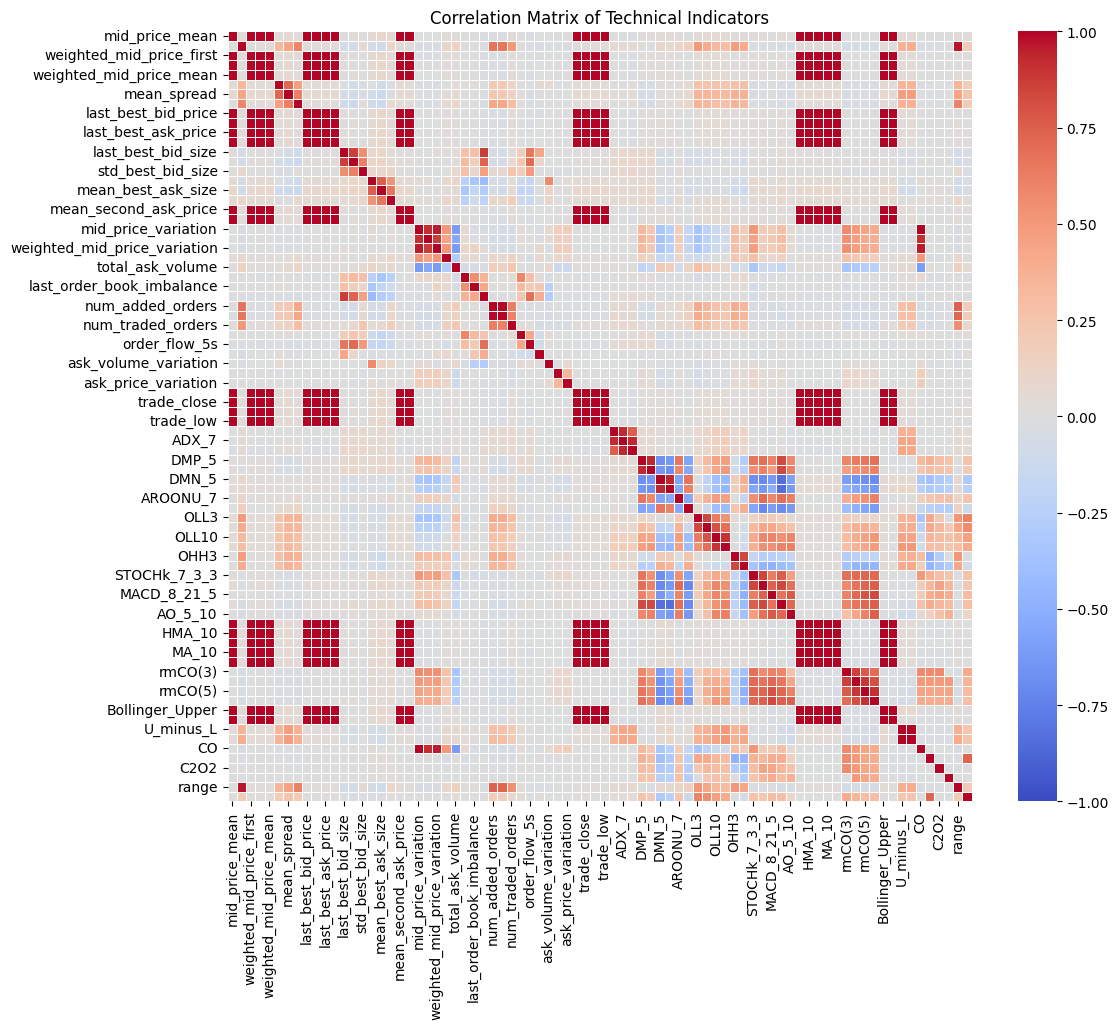

In [14]:
import seaborn as sns

correlation_matrix = all_data.drop(columns=["mid_price_variation_class", "weighted_mid_price_variation_class", "mean_mid_price_variation_class"]).corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix of Technical Indicators")
plt.show()

# Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

X = all_data.drop(columns=['mid_price_variation_class', 'weighted_mid_price_variation_class', "mean_mid_price_variation_class"])  # Features

X_LOB = all_data[order_book_features]
X_technical =all_data[technical_features]
y = all_data['mean_mid_price_variation_class']  # Target variable

params0 = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}
params1 = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

params2={
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 10,
    'min_samples_leaf': 5
}
params3={
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features' : 0.3
}

def analyze_feature_importance(X, y, num_features=None, **rf_params):
    """
    Analyze and visualize feature importance using a Random Forest model.

    Parameters:
        X (pd.DataFrame): DataFrame containing the features.
        y (pd.Series): Series containing the target variable.
        num_features (int): Number of top features to display and plot.
        **rf_params: Additional parameters to pass to RandomForestClassifier.

    Returns:
        importance_df (pd.DataFrame): DataFrame containing features and their importance scores.
    """
    # Initialize the Random Forest model
    rf = RandomForestRegressor(**rf_params)

    # Train the model on the entire dataset
    rf.fit(X, y)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame to display feature importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })

    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    if num_features is None:
        num_features = len(importance_df)

    # Display the top `num_features` most important features
    print(f"Top {num_features} Most Important Features:")
    print(importance_df.head(num_features))

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:num_features], importance_df['Importance'][:num_features], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Top {num_features} Most Important Features')
    plt.gca().invert_yaxis() 
    plt.show()

    return importance_df



Top 25 Most Important Features:
            Feature  Importance
2            ADX_10    0.044730
0             ADX_5    0.044374
17      MACD_8_21_5    0.043450
6            DMN_10    0.042464
5             DMN_5    0.042427
16     STOCHd_7_3_3    0.041498
18            RSI_7    0.041343
3             DMP_5    0.040993
4            DMP_10    0.040982
19          AO_5_10    0.038973
1             ADX_7    0.037366
31        U_minus_L    0.035970
32         MA20dSTD    0.035135
15     STOCHk_7_3_3    0.028586
28          rmCO(6)    0.026107
36             C3O3    0.025774
35             C2O2    0.024854
27          rmCO(5)    0.024038
26          rmCO(4)    0.021765
25          rmCO(3)    0.021389
29  Bollinger_Upper    0.021077
34             C1O1    0.020533
12            OLL15    0.019467
30  Bollinger_Lower    0.018961
33               CO    0.017896


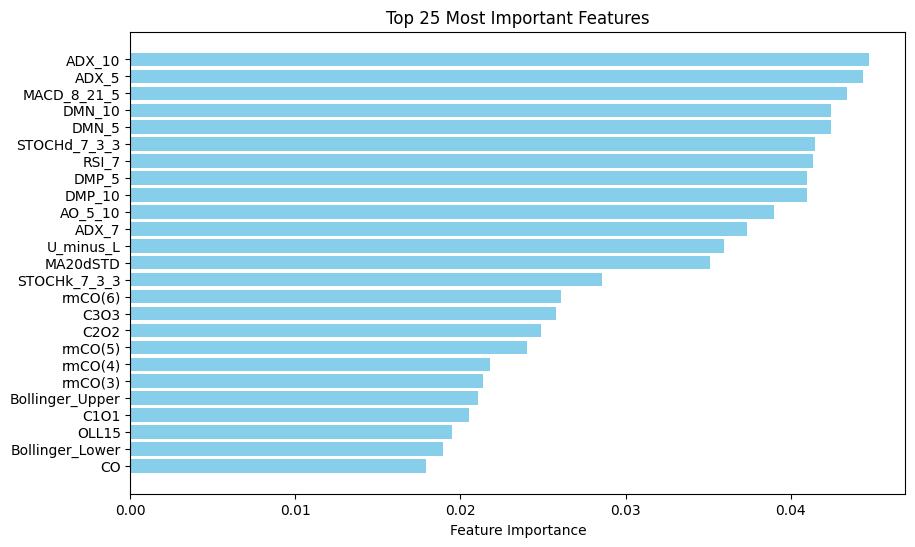

Top 25 Most Important Features:
            Feature  Importance
17      MACD_8_21_5    0.044182
18            RSI_7    0.044035
2            ADX_10    0.043918
0             ADX_5    0.043027
5             DMN_5    0.042697
6            DMN_10    0.042284
4            DMP_10    0.041686
3             DMP_5    0.041408
16     STOCHd_7_3_3    0.040286
19          AO_5_10    0.039113
1             ADX_7    0.037751
31        U_minus_L    0.036294
32         MA20dSTD    0.035002
15     STOCHk_7_3_3    0.028063
36             C3O3    0.026061
28          rmCO(6)    0.025708
35             C2O2    0.025250
27          rmCO(5)    0.023937
26          rmCO(4)    0.021650
29  Bollinger_Upper    0.021427
25          rmCO(3)    0.021167
34             C1O1    0.020682
12            OLL15    0.019325
30  Bollinger_Lower    0.019225
33               CO    0.017520


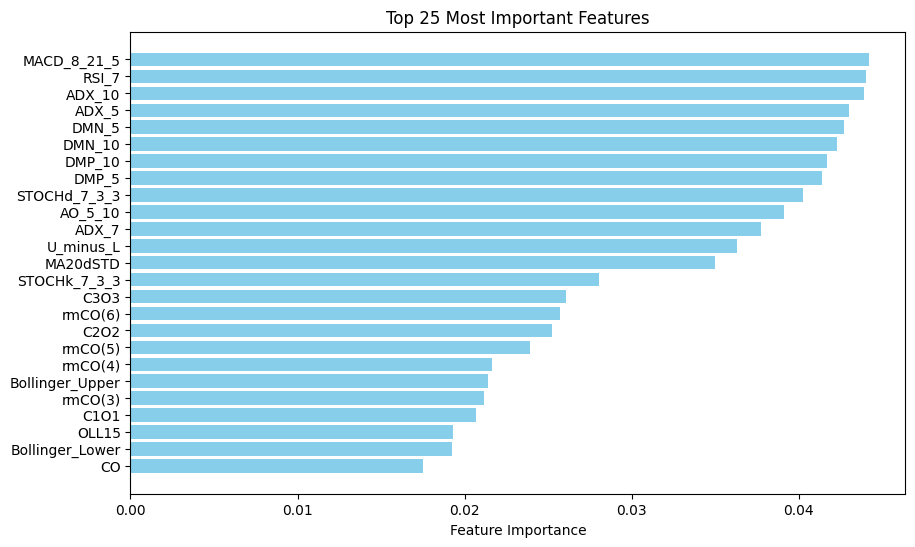

In [19]:
importance_df0 = analyze_feature_importance(X_technical, y, num_features=25, **params0)
importance_df1 = analyze_feature_importance(X_technical, y, num_features=25, **params1)
# importance_df2 = analyze_feature_importance(X, y, **params2)
# importance_df3 = analyze_feature_importance(X, y, **params3)

Top 25 Most Important Features:
                         Feature  Importance
26     last_order_book_imbalance    0.048221
24              total_ask_volume    0.047455
31       order_book_imbalance_5s    0.046845
23              total_bid_volume    0.046543
32                 order_flow_5s    0.044164
17             std_best_ask_size    0.043592
14             std_best_bid_size    0.043284
34          ask_volume_variation    0.043227
33          bid_volume_variation    0.041798
6                    mean_spread    0.041079
25     mean_order_book_imbalance    0.040679
7                     std_spread    0.040106
16            mean_best_ask_size    0.039754
13            mean_best_bid_size    0.039192
21      mean_mid_price_variation    0.037734
1                  std_mid_price    0.037232
22  weighted_mid_price_variation    0.036390
15            last_best_ask_size    0.033120
27          total_net_order_flow    0.031533
29           num_canceled_orders    0.030523
28              num_add

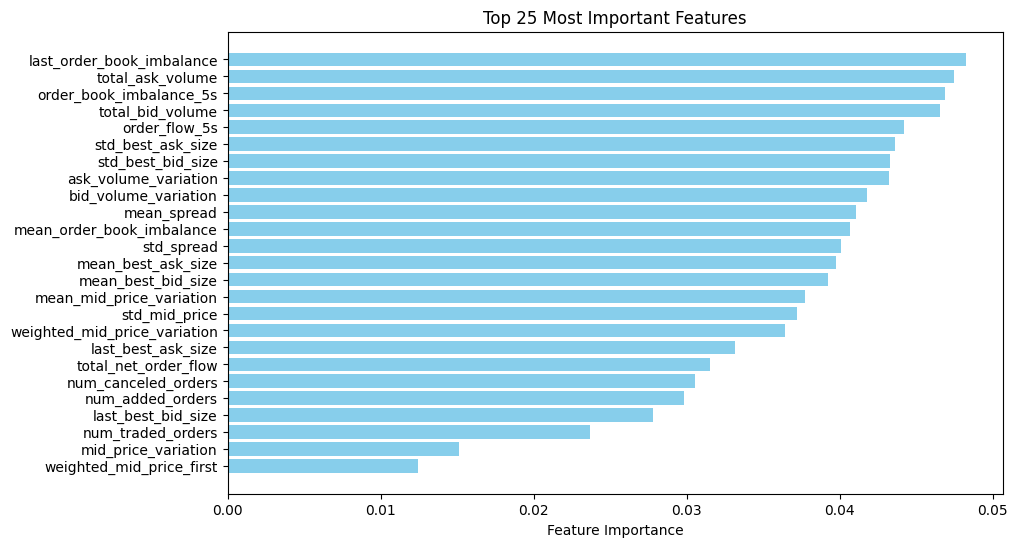

Top 25 Most Important Features:
                         Feature  Importance
26     last_order_book_imbalance    0.048768
24              total_ask_volume    0.047823
31       order_book_imbalance_5s    0.046169
23              total_bid_volume    0.045970
32                 order_flow_5s    0.044412
14             std_best_bid_size    0.043718
17             std_best_ask_size    0.043702
34          ask_volume_variation    0.042853
33          bid_volume_variation    0.042125
25     mean_order_book_imbalance    0.040652
6                    mean_spread    0.040192
13            mean_best_bid_size    0.039748
16            mean_best_ask_size    0.039485
7                     std_spread    0.039361
21      mean_mid_price_variation    0.038234
1                  std_mid_price    0.037962
22  weighted_mid_price_variation    0.035906
15            last_best_ask_size    0.033462
27          total_net_order_flow    0.030652
29           num_canceled_orders    0.030531
28              num_add

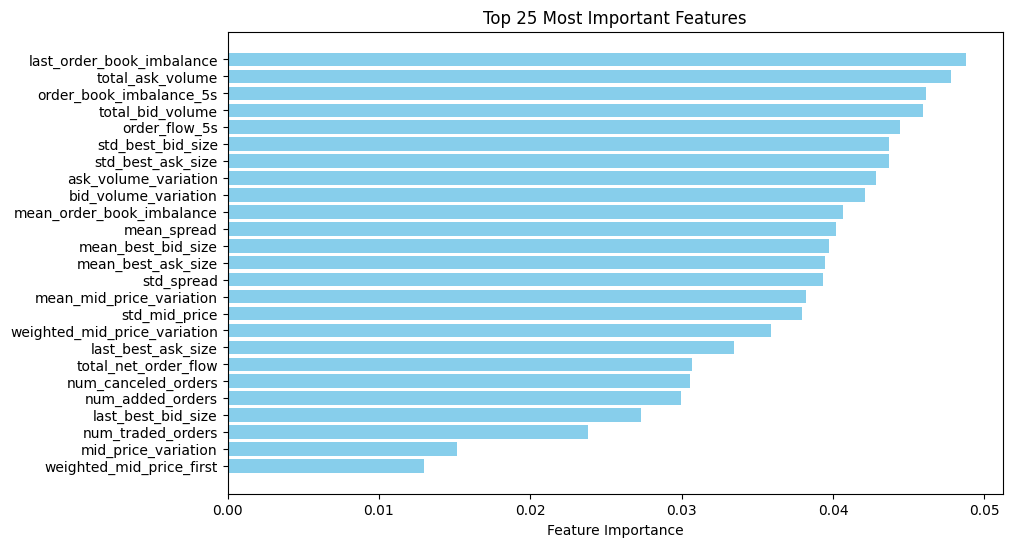

In [20]:
importance_df2 = analyze_feature_importance(X_LOB, y, num_features=25, **params0)
importance_df3 = analyze_feature_importance(X_LOB, y, num_features=25, **params1)

Top 15 Most Important Features:
     Feature  Importance
2     ADX_10    0.102221
5      DMN_5    0.101174
0      ADX_5    0.100960
6     DMN_10    0.100764
4     DMP_10    0.100530
3      DMP_5    0.099854
1      ADX_7    0.092078
12     OLL15    0.047818
14      OHH5    0.043657
11     OLL10    0.039785
9       OLL3    0.037678
13      OHH3    0.036926
10      OLL5    0.036582
8   AROOND_7    0.030162
7   AROONU_7    0.029812


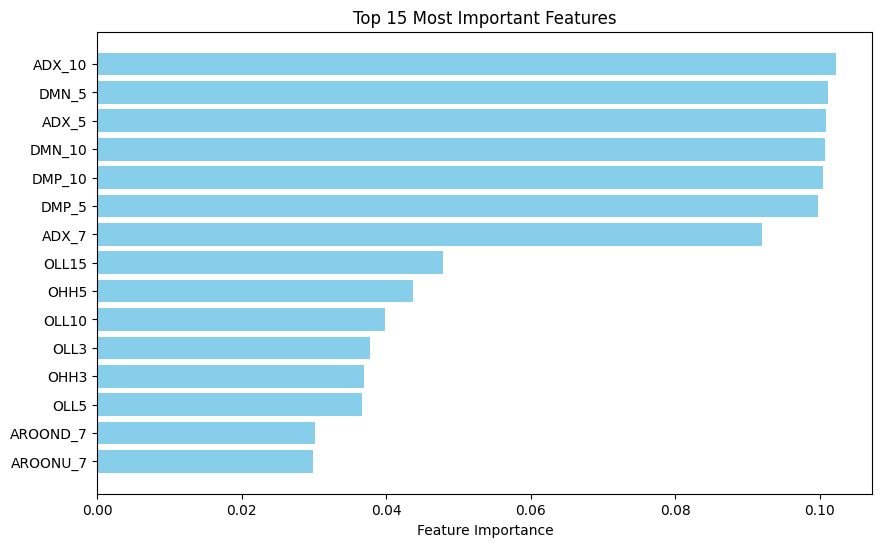

Top 5 Most Important Features:
        Feature  Importance
3         RSI_7    0.241992
2   MACD_8_21_5    0.241467
1  STOCHd_7_3_3    0.199248
4       AO_5_10    0.191096
0  STOCHk_7_3_3    0.126197


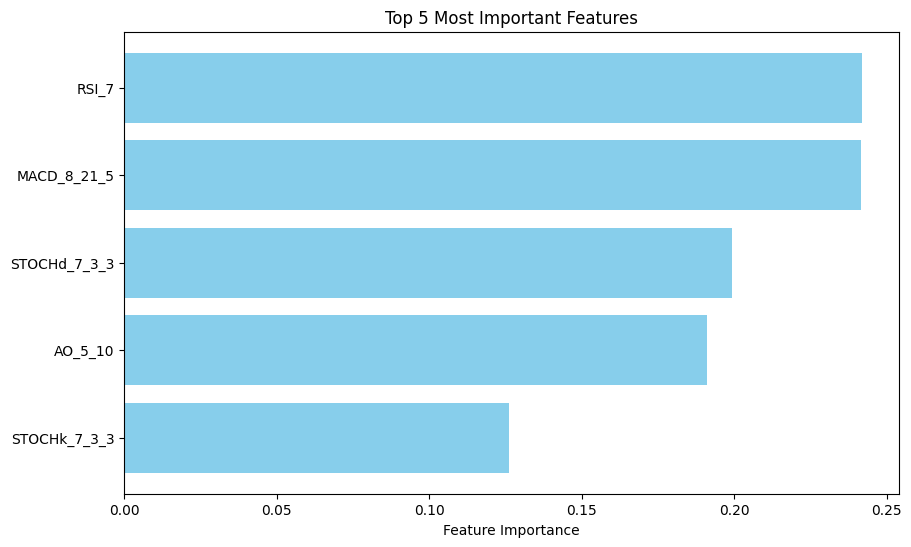

Top 9 Most Important Features:
       Feature  Importance
4        MA_20    0.166344
2  KAMA_3_2_10    0.132753
0       EMA_15    0.123896
3        MA_10    0.123468
1       HMA_10    0.110662
8      rmCO(6)    0.093838
7      rmCO(5)    0.085816
5      rmCO(3)    0.081904
6      rmCO(4)    0.081318


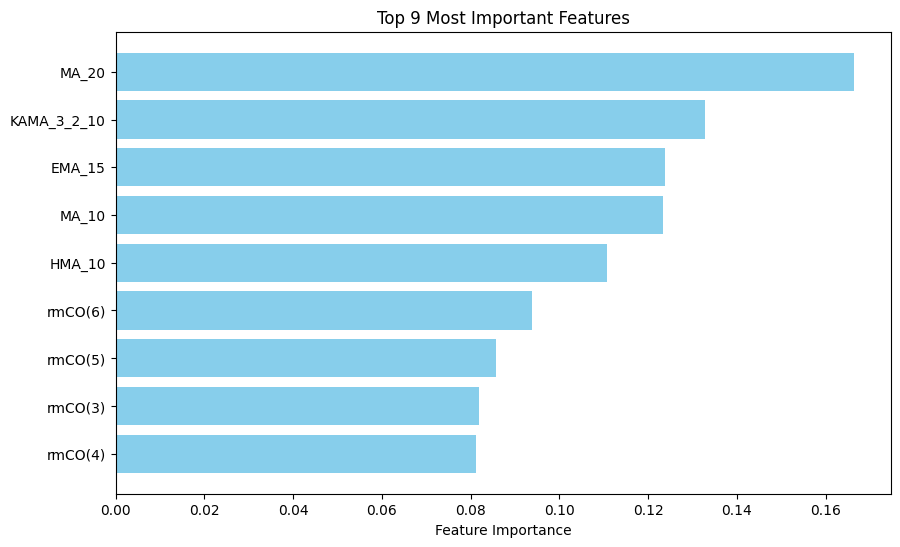

Top 4 Most Important Features:
           Feature  Importance
2        U_minus_L    0.254193
1  Bollinger_Lower    0.250132
3         MA20dSTD    0.248001
0  Bollinger_Upper    0.247674


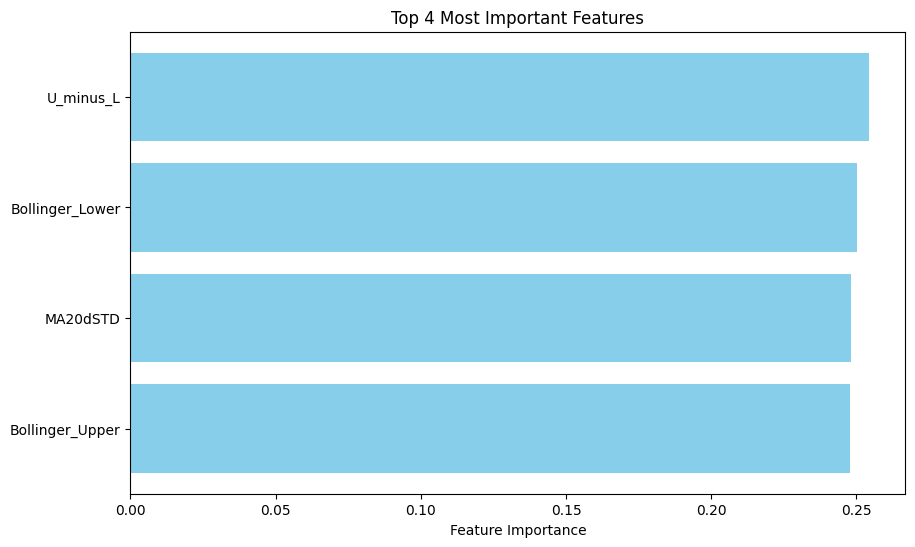

Top 6 Most Important Features:
  Feature  Importance
3    C3O3    0.217840
2    C2O2    0.212177
1    C1O1    0.176101
0      CO    0.162792
4   range    0.120831
5     OH1    0.110259


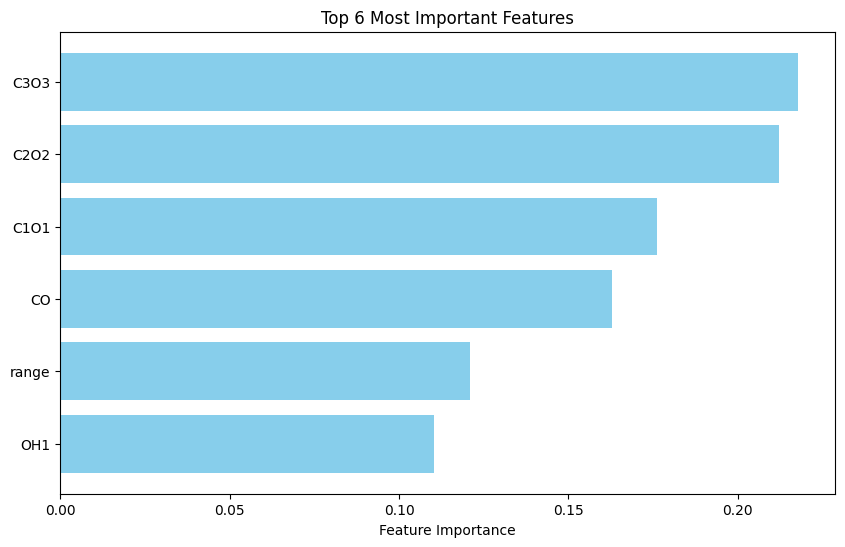

In [21]:
# Technical indicators
trend_indicators = ['ADX_5', 'ADX_7', 'ADX_10', 'DMP_5', 'DMP_10', 'DMN_5', 'DMN_10', 'AROONU_7', 'AROOND_7', 'OLL3', 'OLL5', 'OLL10', 'OLL15', 'OHH3', 'OHH5']
oscillators =[ 'STOCHk_7_3_3', 'STOCHd_7_3_3', 'MACD_8_21_5', 'RSI_7', 'AO_5_10']
moving_averages = ['EMA_15', 'HMA_10', 'KAMA_3_2_10', 'MA_10', 'MA_20', 'rmCO(3)', 'rmCO(4)', 'rmCO(5)', 'rmCO(6)']
volatility_indicators = ['Bollinger_Upper', 'Bollinger_Lower', 'U_minus_L', 'MA20dSTD']
other_indicators = ['CO', 'C1O1', 'C2O2', 'C3O3', 'range', 'OH1']

# LOB specific indicators
mid_price_indicators = ['mid_price_mean', 'std_mid_price', 'weighted_mid_price_first', 'weighted_mid_price_mean',
       'weighted_mid_price_last', 'mid_price_variation', 'weighted_mid_price_variation']
bid_ask_prices_indicators = ['last_best_bid_price',
       'mean_best_bid_price', 'last_best_ask_price', 'mean_best_ask_price', 'bid_price_variation', 'ask_price_variation', 'last_spread',
       'mean_spread', 'std_spread', 'mean_second_ask_price', 'mean_second_bid_price']
volume_indicators = ['last_best_bid_size', 'mean_best_bid_size', 'std_best_bid_size',
       'last_best_ask_size', 'mean_best_ask_size', 'std_best_ask_size','bid_volume_variation', 'ask_volume_variation','total_bid_volume',
       'total_ask_volume',]
orders_indicators = ['total_net_order_flow', 'num_added_orders', 'mean_order_book_imbalance',
       'last_order_book_imbalance', 'order_book_imbalance_5s',
       'order_flow_5s', 
       'num_canceled_orders', 'num_traded_orders', ]

ohlc_indicators = ['trade_open', 'trade_close', 'trade_high', 'trade_low']

importance_df_trend = analyze_feature_importance(X[trend_indicators], y, **params0)
importance_df_oscillators = analyze_feature_importance(X[oscillators], y, **params1)
importance_df_MA = analyze_feature_importance(X[moving_averages], y, **params2)
importance_df_volatility_indicators = analyze_feature_importance(X[volatility_indicators], y, **params3)
importance_df_other = analyze_feature_importance(X[other_indicators], y, **params0)


Top 7 Most Important Features:
                        Feature  Importance
1                 std_mid_price    0.255500
6  weighted_mid_price_variation    0.239930
2      weighted_mid_price_first    0.114400
4       weighted_mid_price_last    0.112501
0                mid_price_mean    0.108590
3       weighted_mid_price_mean    0.107349
5           mid_price_variation    0.061731


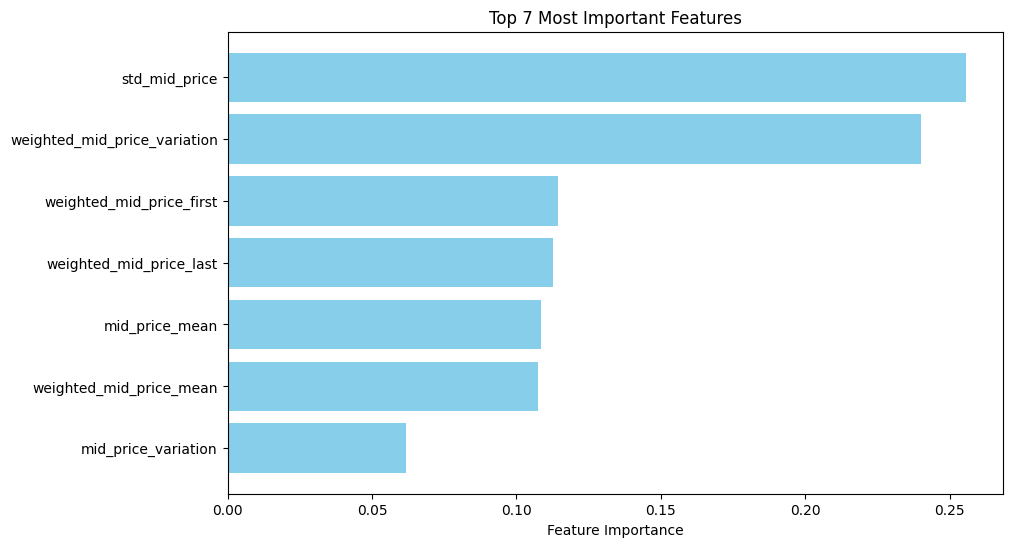

Top 11 Most Important Features:
                  Feature  Importance
8              std_spread    0.272472
7             mean_spread    0.258631
9   mean_second_ask_price    0.086799
10  mean_second_bid_price    0.086696
1     mean_best_bid_price    0.083080
3     mean_best_ask_price    0.082694
0     last_best_bid_price    0.053985
2     last_best_ask_price    0.051859
6             last_spread    0.021546
5     ask_price_variation    0.001163
4     bid_price_variation    0.001076


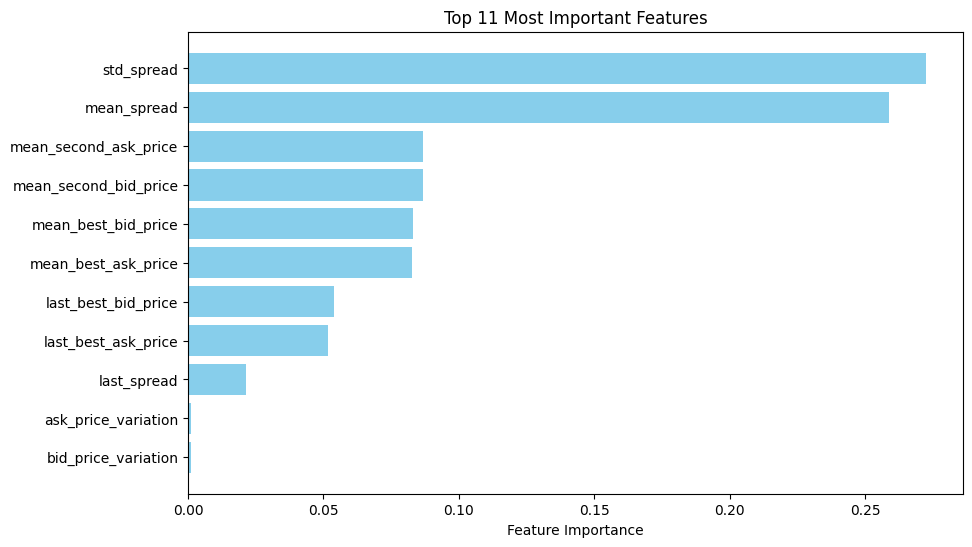

Top 10 Most Important Features:
                Feature  Importance
9      total_ask_volume    0.104952
8      total_bid_volume    0.104938
4    mean_best_ask_size    0.104805
2     std_best_bid_size    0.103565
5     std_best_ask_size    0.103272
1    mean_best_bid_size    0.102796
7  ask_volume_variation    0.095878
3    last_best_ask_size    0.095224
6  bid_volume_variation    0.094985
0    last_best_bid_size    0.089585


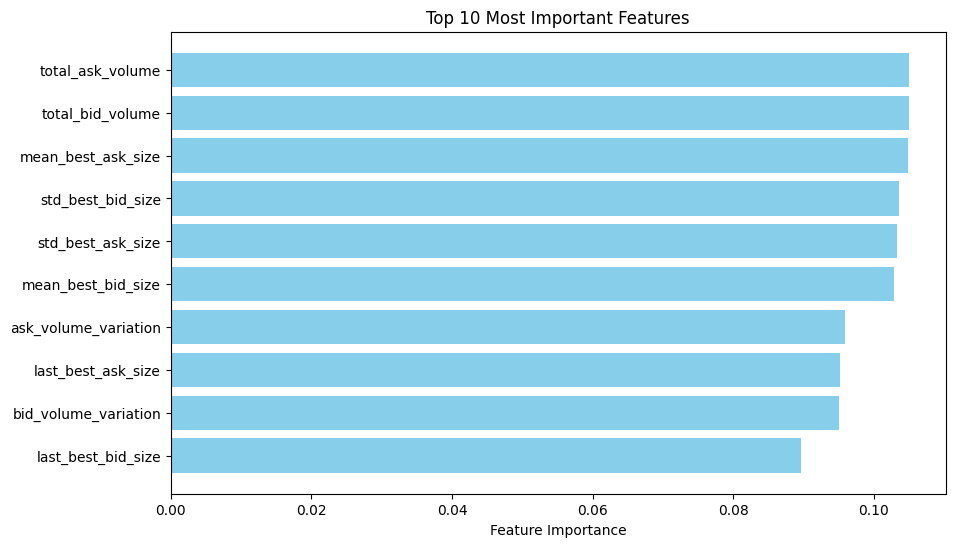

Top 8 Most Important Features:
                     Feature  Importance
2  mean_order_book_imbalance    0.153515
3  last_order_book_imbalance    0.150269
4    order_book_imbalance_5s    0.150086
5              order_flow_5s    0.145290
0       total_net_order_flow    0.128330
1           num_added_orders    0.098179
6        num_canceled_orders    0.098021
7          num_traded_orders    0.076309


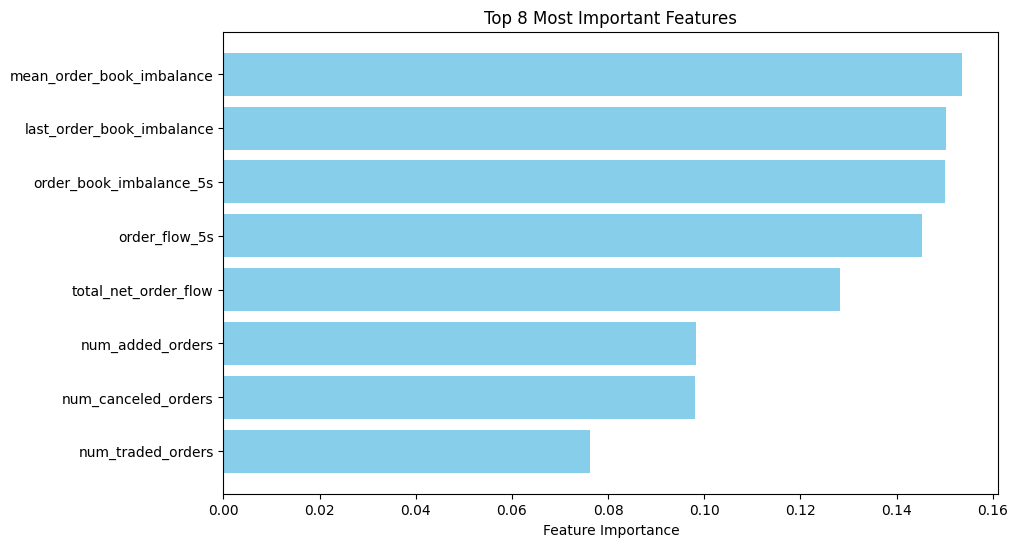

In [24]:
importance_df_mid_price = analyze_feature_importance(X[mid_price_indicators], y, **params1)
importance_df_bid_ask = analyze_feature_importance(X[bid_ask_prices_indicators], y, **params2)
importance_df_volume = analyze_feature_importance(X[volume_indicators], y, **params3)
importance_df_orders = analyze_feature_importance(X[orders_indicators], y, **params0)

# Mutual Info Scores

In [25]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

X = all_data.drop(columns=['mid_price_variation_class', 'weighted_mid_price_variation_class', "mean_mid_price_variation_class"])  # Features
y = all_data['weighted_mid_price_variation_class']  # Target variable

def analyze_mutual_information(X, y, num_features=None, discrete_features='auto', random_state=None):
    """
    Analyze and visualize feature importance using Mutual Information.

    Parameters:
        X (pd.DataFrame): DataFrame containing the features.
        y (pd.Series): Series containing the target variable.
        num_features (int): Number of top features to display and plot.
        discrete_features (str or array-like): Whether to treat features as discrete. 
            'auto' infers it from the data.
        random_state (int): Random seed for reproducibility.

    Returns:
        mi_df (pd.DataFrame): DataFrame containing features and their mutual information scores.
    """
    # Calculate Mutual Information scores
    if y.dtype == 'object' or y.dtype.name == 'category':
        mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=random_state)
    else:
        mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)

    # Create a DataFrame to display MI scores
    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Information': mi_scores
    })

    # Sort features by MI scores
    mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

    if num_features is None:
        num_features = len(mi_df)

    # Display the top `num_features` features with the highest MI scores
    print(f"Top {num_features} Features by Mutual Information:")
    print(mi_df.head(num_features))

    # Plot MI scores
    plt.figure(figsize=(10, 6))
    plt.barh(mi_df['Feature'][:num_features], mi_df['Mutual_Information'][:num_features], color='lightgreen')
    plt.xlabel('Mutual Information Score')
    plt.title(f'Top {num_features} Features by Mutual Information')
    plt.gca().invert_yaxis() 
    plt.show()

    return mi_df


Top 20 Features by Mutual Information:
         Feature  Mutual_Information
33            CO            0.402107
15  STOCHk_7_3_3            0.122739
25       rmCO(3)            0.081552
26       rmCO(4)            0.064936
8       AROOND_7            0.057157
27       rmCO(5)            0.053809
7       AROONU_7            0.048397
13          OHH3            0.045343
28       rmCO(6)            0.043820
9           OLL3            0.040598
3          DMP_5            0.033262
5          DMN_5            0.031512
14          OHH5            0.028235
10          OLL5            0.025110
16  STOCHd_7_3_3            0.022405
18         RSI_7            0.020539
4         DMP_10            0.014425
11         OLL10            0.013483
6         DMN_10            0.011848
17   MACD_8_21_5            0.011073


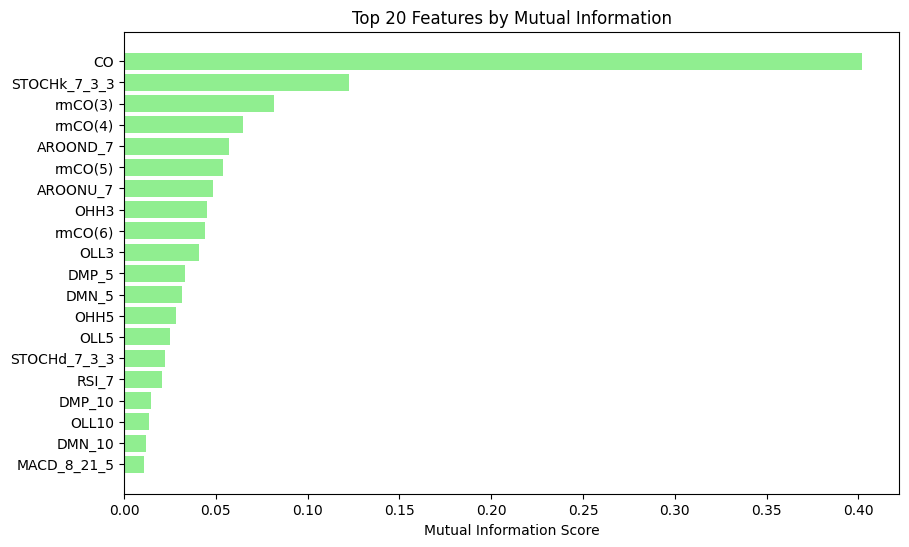

In [26]:
mi_df_technical = analyze_mutual_information(X_technical, y, num_features=20)

Top 20 Features by Mutual Information:
                         Feature  Mutual_Information
22  weighted_mid_price_variation            0.692656
20           mid_price_variation            0.413090
21      mean_mid_price_variation            0.306263
24              total_ask_volume            0.263937
23              total_bid_volume            0.258627
12            last_best_bid_size            0.013557
14             std_best_bid_size            0.011796
13            mean_best_bid_size            0.011409
25     mean_order_book_imbalance            0.011160
34          ask_volume_variation            0.011113
36           ask_price_variation            0.010550
26     last_order_book_imbalance            0.008923
17             std_best_ask_size            0.008744
0                 mid_price_mean            0.005952
35           bid_price_variation            0.005664
16            mean_best_ask_size            0.005320
2       weighted_mid_price_first            0.004900
33     

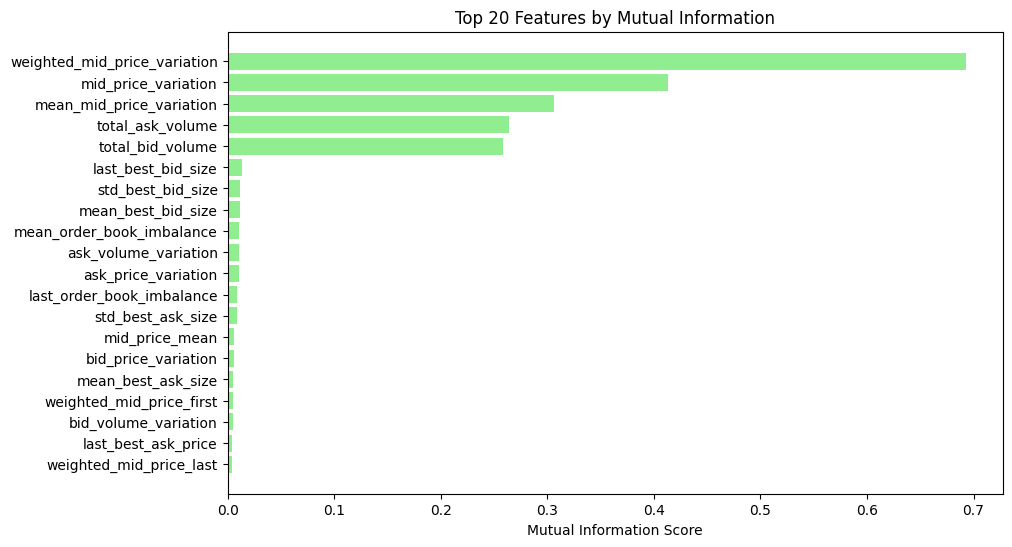

In [27]:
mi_df_LOB = analyze_mutual_information(X_LOB, y, num_features=20)

# SHAP Importance Scores

In [28]:
import shap
import xgboost as xgb

y = all_data['mean_mid_price_variation_class']  # Target variable

def analyze_shap_values(X, y, max_display=30, top_n_features=25):
    """
    Train an XGBoost model, perform SHAP analysis, and plot the results.

    Parameters:
        X (pd.DataFrame): DataFrame containing the features.
        y (pd.Series): Series containing the target variable.
        max_display (int): Number of top features to display in the SHAP summary plot.
        top_n_features (int): Number of top features to display in the mean absolute SHAP values plot.

    Returns:
        shap_df (pd.DataFrame): DataFrame containing features and their mean absolute SHAP values.
    """
    # Train XGBoost model
    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(X, y)

    # SHAP Analysis
    explainer = shap.Explainer(xgb_model, X)
    shap_values = explainer(X)

    # Show more values in the SHAP summary plot
    shap.summary_plot(shap_values, X, max_display=max_display)

    # Calculate mean absolute SHAP values
    mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': X.columns,
        'Mean Absolute SHAP Value': mean_abs_shap_values
    }).sort_values(by='Mean Absolute SHAP Value', ascending=False)

    # Plot mean absolute SHAP values for the top N features
    top_features = shap_df.head(top_n_features)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Mean Absolute SHAP Value'], color='skyblue')
    plt.xlabel('Mean Absolute SHAP Value')
    plt.title(f'Top {top_n_features} Mean Absolute SHAP Values for Features')
    plt.gca().invert_yaxis()
    plt.show()

    print(top_features)
    return shap_df

100%|===================| 44600/44767 [02:16<00:00]        

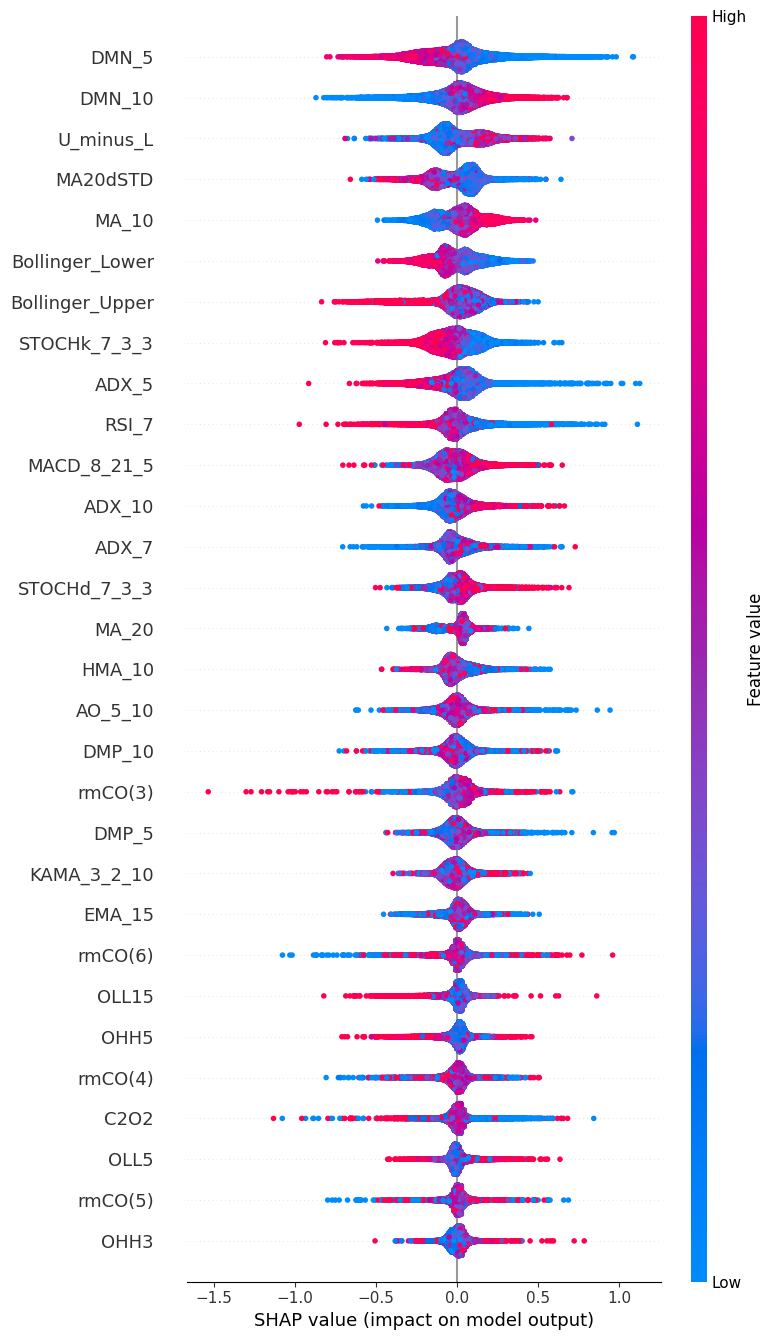

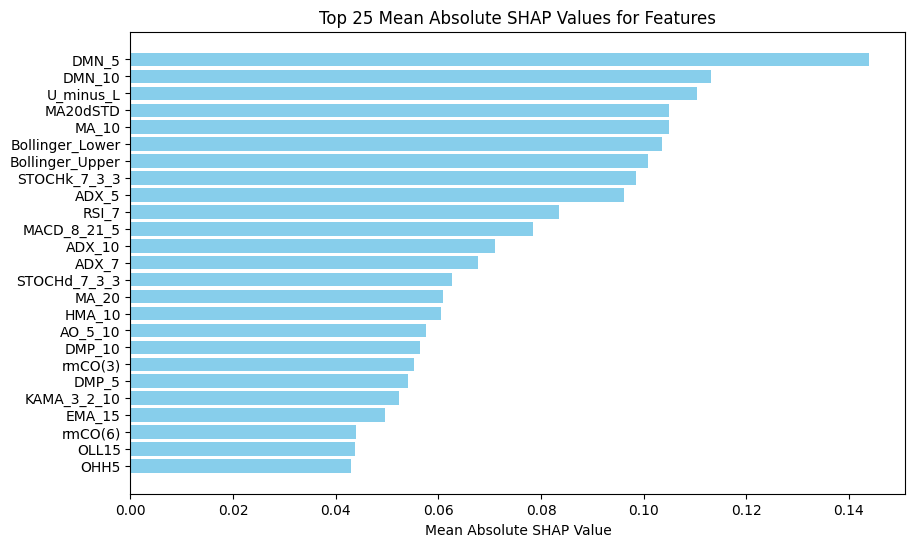

            Feature  Mean Absolute SHAP Value
5             DMN_5                  0.143825
6            DMN_10                  0.113184
31        U_minus_L                  0.110490
32         MA20dSTD                  0.105029
23            MA_10                  0.104860
30  Bollinger_Lower                  0.103661
29  Bollinger_Upper                  0.100819
15     STOCHk_7_3_3                  0.098596
0             ADX_5                  0.096260
18            RSI_7                  0.083429
17      MACD_8_21_5                  0.078352
2            ADX_10                  0.071063
1             ADX_7                  0.067631
16     STOCHd_7_3_3                  0.062624
24            MA_20                  0.060952
21           HMA_10                  0.060488
19          AO_5_10                  0.057576
4            DMP_10                  0.056388
25          rmCO(3)                  0.055192
3             DMP_5                  0.053986
22      KAMA_3_2_10               

In [29]:
shap_df_technical = analyze_shap_values(X_technical, y, max_display=30, top_n_features=25)

 99%|===================| 44527/44767 [02:17<00:00]        

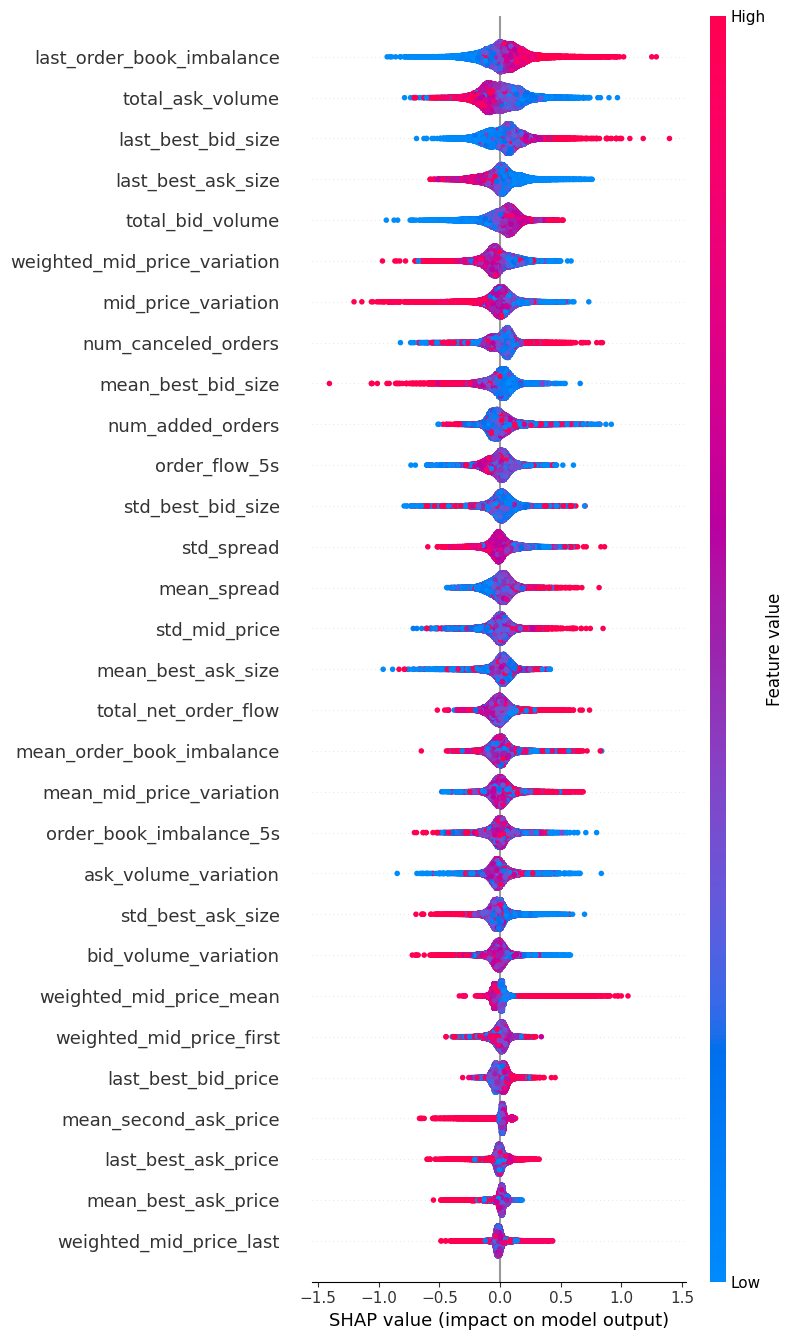

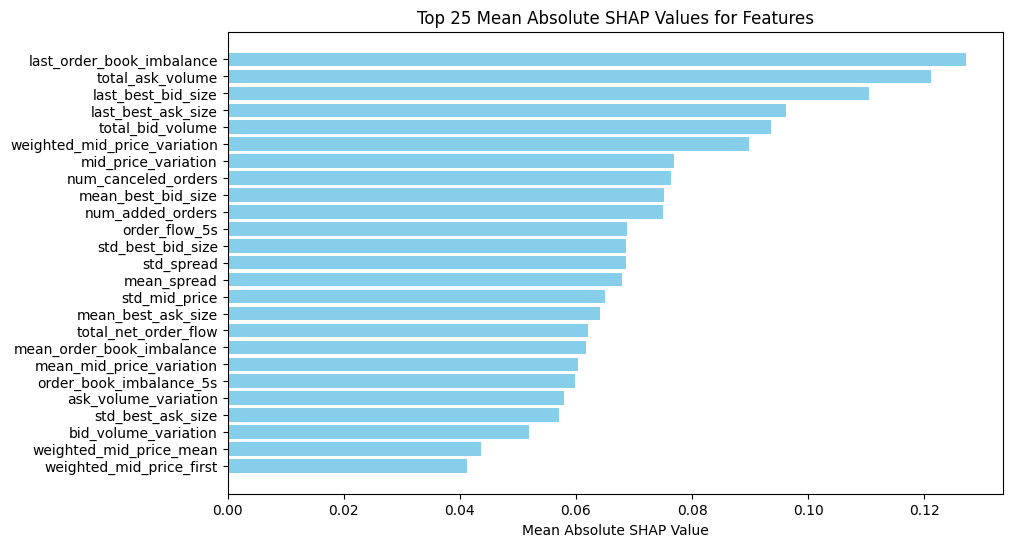

                         Feature  Mean Absolute SHAP Value
26     last_order_book_imbalance                  0.127131
24              total_ask_volume                  0.121142
12            last_best_bid_size                  0.110470
15            last_best_ask_size                  0.096259
23              total_bid_volume                  0.093555
22  weighted_mid_price_variation                  0.089793
20           mid_price_variation                  0.076824
29           num_canceled_orders                  0.076369
13            mean_best_bid_size                  0.075173
28              num_added_orders                  0.074956
32                 order_flow_5s                  0.068762
14             std_best_bid_size                  0.068635
7                     std_spread                  0.068547
6                    mean_spread                  0.067988
1                  std_mid_price                  0.065067
16            mean_best_ask_size                  0.0641

In [30]:
shap_df_LOB = analyze_shap_values(X_LOB, y, max_display=30, top_n_features=25)

# PCA

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_feature_selection(df, n_components=None, variance_threshold=0.95, num_features_to_keep=20):
    """
    Perform PCA-based feature selection and visualize the importance of the selected features.

    Parameters:
    - df: pandas DataFrame, the input dataset.
    - n_components: int or None, the number of principal components to keep. If None, it will be determined by the variance_threshold.
    - variance_threshold: float, the cumulative explained variance threshold to use if n_components is None.
    - num_features_to_keep: int, the number of top features to select.

    Returns:
    - features_to_keep: list, the names of the selected features.
    - sum_loadings: numpy array, the importance scores of the selected features.
    - selected_components_df: pandas DataFrame, the PCA components for the selected features.
    """
    # Step 1: Extract feature names and data
    features = df.columns.tolist() 
    X = df.values 

    # Step 2: Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 3: Apply PCA
    if n_components is None:
        # Compute all components to analyze explained variance
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)
        
        # Calculate cumulative explained variance
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        # Determine the number of components to retain based on the variance threshold
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        print(f"Selected {n_components} components to explain {variance_threshold * 100}% of the variance.")
        
        # Re-fit PCA with the selected number of components
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
    else:
        # Use the specified number of components
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)

    # Step 4: Get PCA components (loadings)
    components = pca.components_  # Each row is a principal component, each column is a feature
    components_df = pd.DataFrame(components, columns=features, index=[f'PC{i+1}' for i in range(len(components))])

    # Step 5: Calculate absolute factor loadings and sum them
    absolute_loadings = np.abs(components)  # Absolute values of loadings
    sum_loadings = np.sum(absolute_loadings, axis=0)  # Sum of loadings for each feature

    # Step 6: Sort features by importance
    sorted_indices = np.argsort(sum_loadings)[::-1]  # Indices of features sorted by importance

    # Step 7: Select top features
    features_to_keep = [features[i] for i in sorted_indices[:num_features_to_keep]]  # Top features

    # Step 8: Display results
    print("Top Features to Keep:", features_to_keep)
    print("\nImportance of Selected Features:")
    for feature in features_to_keep:
        index = features.index(feature)
        print(f"{feature}: Importance = {sum_loadings[index]:.4f}")

    # Step 9: Display PCA components for selected features
    selected_components_df = components_df[features_to_keep]
    print("\nPCA Components for Selected Features:")
    print(selected_components_df)

    # Step 10: Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features_to_keep), sum_loadings[sorted_indices[:num_features_to_keep]], align='center', color='skyblue')
    plt.xticks(range(num_features_to_keep), features_to_keep, rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance (Sum of Absolute Loadings)')
    plt.title('Top Features by Importance')
    plt.tight_layout()
    plt.show()

    return features_to_keep, sum_loadings, selected_components_df

Selected 29 components to explain 95.0% of the variance.
Top Features to Keep: ['total_bid_volume', 'ask_volume_variation', 'total_ask_volume', 'order_book_imbalance_5s', 'bid_volume_variation', 'last_order_book_imbalance', 'std_best_bid_size', 'C3O3', 'DMN_10', 'std_best_ask_size', 'last_spread', 'std_spread', 'bid_price_variation', 'num_traded_orders', 'DMP_10', 'ask_price_variation', 'mean_order_book_imbalance', 'U_minus_L', 'mean_best_ask_size', 'C2O2']

Importance of Selected Features:
total_bid_volume: Importance = 3.3872
ask_volume_variation: Importance = 3.3532
total_ask_volume: Importance = 3.2785
order_book_imbalance_5s: Importance = 3.1519
bid_volume_variation: Importance = 3.1192
last_order_book_imbalance: Importance = 3.0853
std_best_bid_size: Importance = 3.0690
C3O3: Importance = 3.0500
DMN_10: Importance = 3.0162
std_best_ask_size: Importance = 3.0068
last_spread: Importance = 2.9633
std_spread: Importance = 2.9147
bid_price_variation: Importance = 2.8575
num_traded_ord

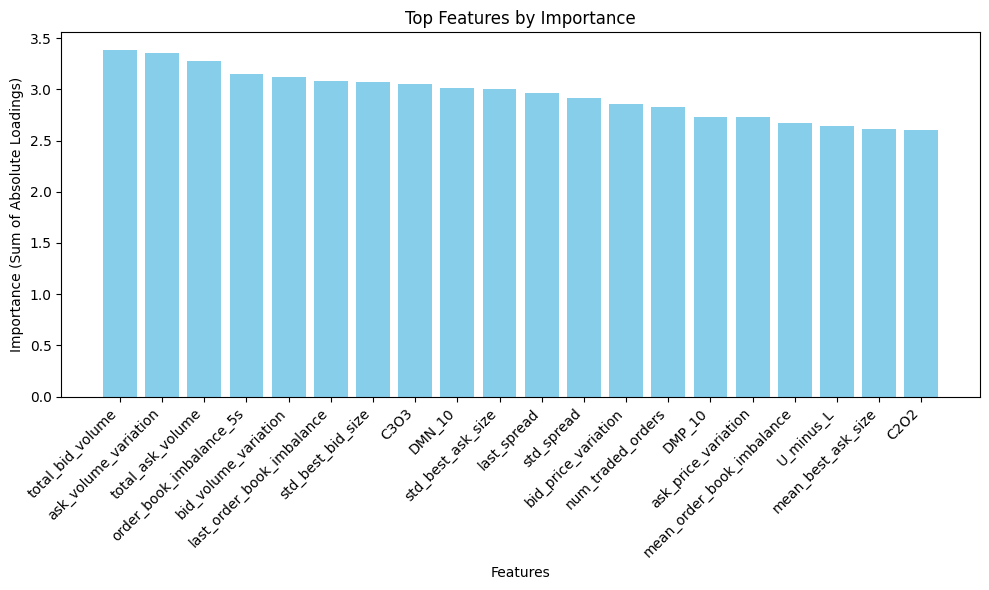

In [32]:
# Change all_data to select feature categories
features_to_keep, sum_loadings, selected_components_df = pca_feature_selection(
    all_data,  num_features_to_keep=20
)

Selected 8 components to explain 95.0% of the variance.
Top Features to Keep: ['AROOND_7', 'AROONU_7', 'OLL3', 'DMN_10']

Importance of Selected Features:
AROOND_7: Importance = 2.2944
AROONU_7: Importance = 2.2501
OLL3: Importance = 2.0512
DMN_10: Importance = 1.8459

PCA Components for Selected Features:
     AROOND_7  AROONU_7      OLL3    DMN_10
PC1 -0.297727  0.314773  0.160780 -0.331793
PC2  0.157658 -0.043085  0.236467  0.168696
PC3  0.175237  0.016158  0.447408  0.155102
PC4 -0.022556  0.198349 -0.224729 -0.127422
PC5  0.351644  0.192999  0.126565  0.325741
PC6  0.568256 -0.501051  0.178728 -0.467247
PC7  0.170826  0.634941  0.273136 -0.180187
PC8  0.550488  0.348739 -0.403400 -0.089754


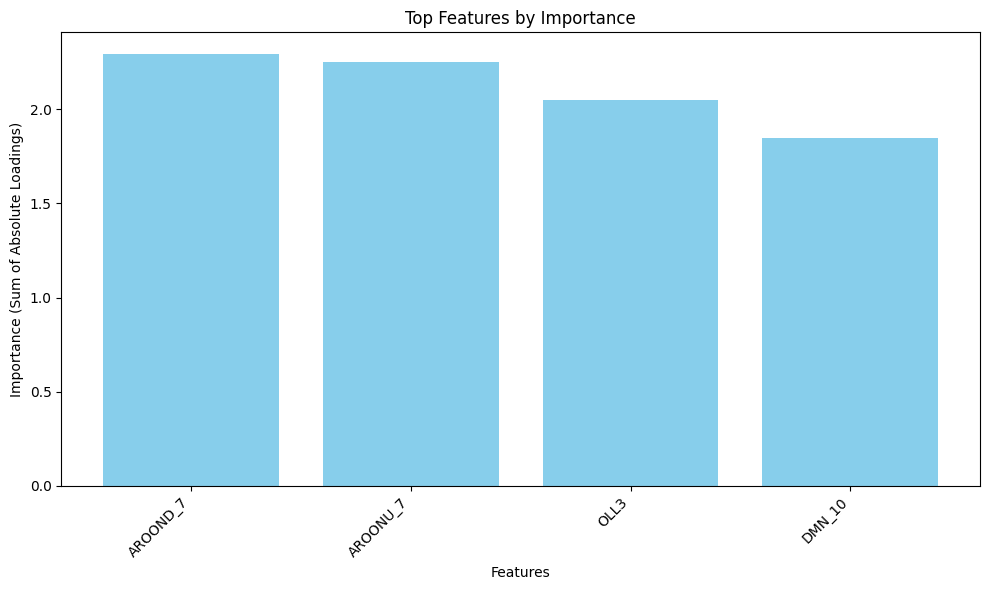

In [33]:
# Change all_data to select feature categories
features_to_keep, sum_loadings, selected_components_df = pca_feature_selection(
    all_data[trend_indicators],  num_features_to_keep=4
)